This notebook shows how to **define** and **visualize** **vector fields** based on **scalar fields**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape, vector_smarter_reshape

from spomso.cores.geom_2d import Circle, Segment, SegmentedLine, ParametricCurve
from spomso.cores.geom_vector import VectorFieldFromSDF
from spomso.cores.post_processing import conv_averaging, linear_falloff

# FUNCTIONS

In [2]:
def lemniscate(t, amplitude):
    # https://en.wikipedia.org/wiki/Lemniscate_of_Bernoulli
    x = amplitude*np.cos(t)/(1 + np.sin(t)**2)
    y = amplitude*np.cos(t)*np.sin(t)/(1 + np.sin(t)**2)
    return np.asarray((x, y))

# PARAMETERS

In [3]:
# size of the volume
co_size = 100, 100, 5.5
# resolution of the volume
co_resolution = 100, 100, 11

# show 2D cross-section along the z-axis
show_midplane = True
# index of the cross-section along the z-axis
depth_index = 0
# 1/decimate of total vectors are shown in the cross-section
decimate = 4

# spline type: "CIRCLE", "LINE", "SEGMENTED_LINE", "PARAMETRIC_CURVE"
spline_type = "CIRCLE"

# show a 3D plot
show_3d = False
show_field = True
show_field_3d = False

There are 4 sub-examples in this notebook showing how to create a vector field from a Signed Distance Function (SDF) of a **curve** or **line** (`spline_type`):

* CIRCLE
* LINE
* SEGMENTED_LINE
* PARAMETRIC CURVE



# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [4]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SCALAR FIELDS

Create a selected **SDF**:

## CIRCLE

In [5]:
if spline_type == "CIRCLE":
    wg = Circle(30)
    wg.boundary()

## LINE

In [6]:
if spline_type=="LINE":
    wg = Segment((-20, 0, 0), (20, 0, 0))
    wg.rotate(np.pi / 12, (0, 0, 1))

## SEGMENTED LINE

In [7]:
if spline_type=="SEGMENTED_LINE":
    segmented_line_points = ((-20, 30, 0),
                             (20, 45, 0),
                             (35, -35, 0),
                             (-40, -40, 0))
    segmented_line_points = np.asarray(segmented_line_points)*0.95
    wg = SegmentedLine(segmented_line_points, True)

## PARAMETRIC CURVE

In [8]:
if spline_type=="PARAMETRIC_CURVE":
    wg = ParametricCurve(lemniscate,
                         (40, ),
                         (0, 2*np.pi, 501),
                         True)
    wg.rotate(-np.pi/4, (0, 0, 1))

Evaluate the **UDF** to create an unsigned distance field 3D map:


In [9]:
wg_pattern = wg.create(coor)

Smooth the **UDF** to avoid artifacts in the final **vector field**:

In [10]:
wg_pattern_smooth = smarter_reshape(wg_pattern, co_resolution)
wg_pattern_smooth = conv_averaging(wg_pattern_smooth, (5, 5, 1), 1)
wg_pattern = wg_pattern_smooth.reshape(wg_pattern.shape)

In the last step we applied a single **iteration** [*third parameter*] convolutional averaging filter (`conv_averaging`) with the **kernel size** of `(5, 5, 1)` [*second_parameter*]. The **kernel size** implies that we are only **smoothing** the field in the **X** and **Y** directions.

A this point the scalar field we calculated is no longer a true UDF since we smoothed the field and potentially changed the distances between points.

## SHOW SCALAR FIELDS

(101, 101, 11)


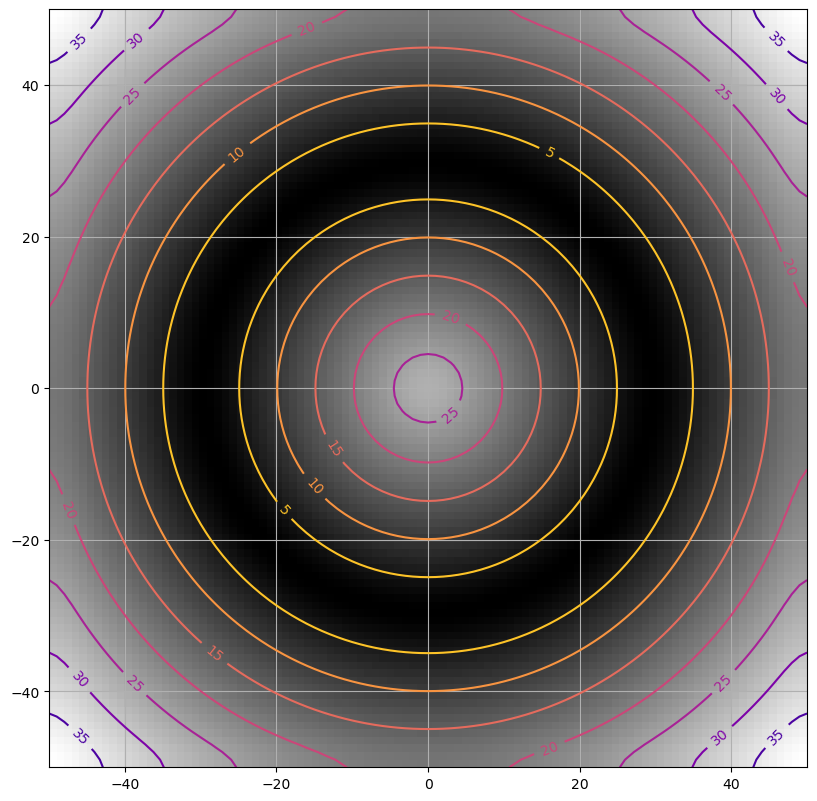

In [11]:
if show_midplane and show_field:
    field = smarter_reshape(wg_pattern, co_resolution)
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :, depth_index].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == -co_size[2]/2
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :, depth_index],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [12]:
if show_field_3d and show_field:
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=wg_pattern,
        isomin=-0,
        isomax=20,
        opacity=0.1,
        surface_count=5,
    ))

    fig.update_layout(
        scene=dict(
            aspectmode="manual",
            aspectratio=dict(x=1, y=co_size[1]/co_size[0], z=co_size[2]/co_size[0])
        )
    )

    fig.show()

# CREATE VECTOR FIELDS

To create the **vector field** use the function `VectorFieldFromSDF` to which we pass the **resolution** (`co_resolution`) of the grid on which the **vector field** will be evaluated:

In [13]:
final = VectorFieldFromSDF(co_resolution)

The **vector field** can be modifed by **rotating** the vectors around an **axis** (ie. the z-axis) for some (spatially dependant) **angle** (`phis_`):

In [14]:
phis_ = linear_falloff(wg_pattern, np.pi/2, 20)
final.rotate_z(phis_)

<function spomso.cores.modifications.ModifyVectorObject.rotate_z.<locals>.new_vf(p, *params)>

The vectors can also be rotated around some arbitrary axis `(1, 0, 0)` for some (spatially dependant) **angle** (`thetas_`):

In [15]:
thetas_ = linear_falloff(wg_pattern, np.pi/6, 20)
final.rotate_axis((1,0,0), thetas_)

<function spomso.cores.modifications.ModifyVectorObject.rotate_axis.<locals>.new_vf(p, *params)>

## EVALUATE

Evaluate the **vector field** functions to create a map of the **vector field**. This is done by calling the **create** method and passing in the evaluated **SDF** (**UDF**):

In [16]:
final_field = final.create(wg_pattern)

# EXTRACT

Extract the **x**, **y**, and **z** components of the **vector field**:

In [17]:
x = final.x(wg_pattern)
y = final.y(wg_pattern)
z = final.z(wg_pattern)

Extract the **phi** (azimuthal) and **theta** (polar) angles, and the vector **lengths**:

In [18]:
phi = final.phi(wg_pattern)
theta = final.theta(wg_pattern)
length = final.length(wg_pattern)

Convert the field maps into grids:

In [19]:
field = vector_smarter_reshape(final_field, co_resolution)
x = smarter_reshape(x, co_resolution)
y = smarter_reshape(y, co_resolution)
z = smarter_reshape(z, co_resolution)
phi = smarter_reshape(phi, co_resolution)
theta = smarter_reshape(theta, co_resolution)
length = smarter_reshape(length, co_resolution)

# PLOT

## XY plane


Drawing results...


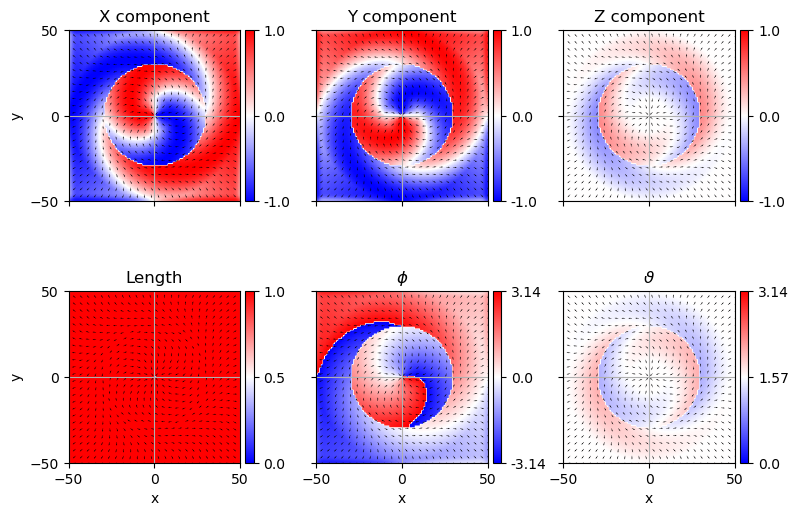

In [20]:
print("Drawing results...")
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=(8.25, 2*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)

            f = ax.imshow(patterns[i][j][:, :, depth_index].T,
                          cmap="bwr",
                          extent=(-co_size[0]/2, co_size[0]/2,
                                  -co_size[1]/2, co_size[1]/2),
                          origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[1]/2, co_size[1]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, ::decimate, depth_index],
                      smarter_reshape(coor[1], co_resolution)[::decimate, ::decimate, depth_index],
                      field[0, ::decimate, ::decimate, depth_index],
                      field[1, ::decimate, ::decimate, depth_index])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("y")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## XZ plane

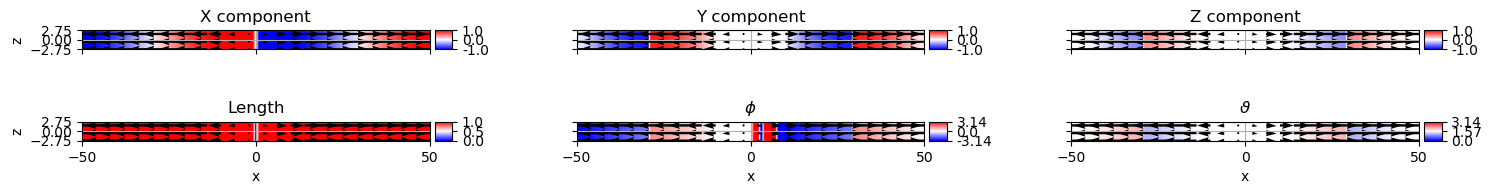

In [21]:
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=(8.25*2, 0.7*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            depth_index_xz = patterns[i][j].shape[1]//2
            f = ax.imshow(patterns[i][j][:, depth_index_xz, :].T,
                      cmap="bwr",
                      extent=(-co_size[0]/2, co_size[0]/2,
                              -co_size[2]/2, co_size[2]/2),
                      origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[2]/2, co_size[2]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, depth_index, ::decimate],
                      smarter_reshape(coor[2], co_resolution)[::decimate, depth_index, ::decimate],
                      field[0, ::decimate, depth_index, ::decimate],
                      field[2, ::decimate, depth_index, ::decimate])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("z")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## 3D

In [22]:
if show_3d:
    decimate3d = 2*decimate
    xx = smarter_reshape(coor[0], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    yy = smarter_reshape(coor[1], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    zz = smarter_reshape(coor[2], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    vx = field[0, ::decimate3d, ::decimate3d, :].flatten()
    vy = field[1, ::decimate3d, ::decimate3d, :].flatten()
    vz = field[2, ::decimate3d, ::decimate3d, :].flatten()
    phi_ = phi[::decimate3d, ::decimate3d, :].flatten()

    fig = go.Figure()

    fig = go.Figure(
        data=go.Cone(
            x=xx,
            y=yy,
            z=zz,
            u=vx,
            v=vy,
            w=vz,
            colorscale='Blues_r',
            sizemode="absolute",
            sizeref=1
        )
    )

    fig.update_layout(
        scene=dict(
            aspectmode="manual",
            aspectratio=dict(x=1, y=co_size[1]/co_size[0], z=10*co_size[2]/co_size[0])
        )
    )

    fig.show()